# Preparação e Exploração de Taxa de Câmbio 

Aqui é explorada a série temporal de taxa de intercâmbio entre YAN (moeda japonesa) e USD (dólar americano), sendo tratados: 
- Valores omissos (imputação/ interpolação)
- Mudança de escala temporal (diária -> mensal) para posterior combinação com outras séries temporais
## Importação e Exploração de Dados

Os dados são obtidos do FRED(Federal Reserve Economic Data) e a frequência temporal é explicitada como Business Days, através da letra B.

In [2]:
import pandas as pd 
import numpy as np 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime 

# seasonal_decompose from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Name id to get data
dataset = 'DEXJPUS'
start = datetime(2003,3, 1)
end = datetime(2023,3, 1)

exchange = web.DataReader(dataset, data_source = 'fred', start=start, end=end)
exchange.index.freq = 'B'
exchange.head(5)

,DEXJPUS
DATE,
2003-03-03,117.93
2003-03-04,117.96
2003-03-05,117.32
2003-03-06,117.22
2003-03-07,116.47


### Verificar valores nulos

Neste passo, confirma-se a utilização das datas como objeto DateTime, com frequência B (Business Days) e verifica-se a existência de valores nulos.

In [3]:
exchange = exchange.rename(columns={'DEXJPUS': 'Rate'})
exchange.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5218 entries, 2003-03-03 to 2023-03-01
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    5015 non-null   float64
dtypes: float64(1)
memory usage: 81.5 KB


### Verificar valores duplicados

Após a verificação de nulos, é feita uma verificação de registos duplicados

In [4]:
exchange[exchange.index.duplicated()]

,Rate
DATE,


Como não se verificam registos duplicados, não há necessidade da sua remoção.

### Visualização da Série Temporal

Neste passo, é representada a série temporal, para ver o seu comportamento. 
Não é aparente, uma tendência fixa ou a existência de sazonalidade.

Text(0.5, 1.0, 'Japanese Yen to U.S. Dollar Spot Exchange Rate')

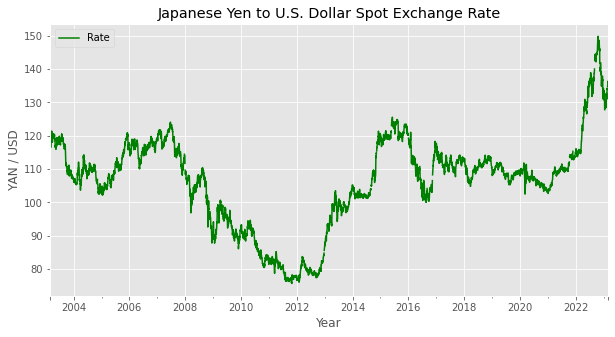

In [5]:
plt.style.use('ggplot')
ax = exchange.plot(color='green', grid=True, figsize=(10,5))
ax.set_xlabel('Year')
ax.set_ylabel('YAN / USD')
ax.set_title('Japanese Yen to U.S. Dollar Spot Exchange Rate') 

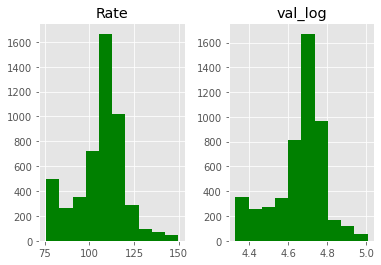

In [6]:
exchange2 = exchange
exchange2['val_log'] = np.log(exchange)
exchange.hist(color='green')
plt.show()

## Imputação / Interpolação de Valores
Como visto anteriormente no gráfico, e na tabela descritiva do _info()_, existem valores nulos, pelo que, neste passo são introduzidos. - ver / mudar -

In [7]:
### impute missing values with different methods

## impute mean
exchange= exchange.assign(FillMean=exchange.Rate.fillna(exchange.Rate.mean()))

## impute median
#df = df.assign(FillMedian=df.GDP.fillna(df.GDP.median()))

## linear interpolation
exchange = exchange.assign(InterpolateLinear=exchange.Rate.interpolate(method='linear'))

##cubic spline interpolation
# df = df.assign(InterpolateCubic=df.GDP.interpolate(method='cubic'))

## impute with the next value 
exchange = exchange.assign(FillF=exchange.Rate.fillna(method='ffill'))

## impute with the previous value
# df = df.assign(FillF=df.GDP.fillna(method='bfill'))

In [8]:
exchange

,Rate,val_log,FillMean,InterpolateLinear,FillF
DATE,,,,,
2003-03-03,117.93,4.770091,117.93,117.93,117.93
2003-03-04,117.96,4.770346,117.96,117.96,117.96
2003-03-05,117.32,4.764905,117.32,117.32,117.32
2003-03-06,117.22,4.764053,117.22,117.22,117.22
2003-03-07,116.47,4.757634,116.47,116.47,116.47
...,...,...,...,...,...
2023-02-23,134.80,4.903792,134.80,134.80,134.80
2023-02-24,136.36,4.915298,136.36,136.36,136.36
2023-02-27,136.18,4.913978,136.18,136.18,136.18


In [9]:
exchange[exchange['Rate'].isna()]

,Rate,val_log,FillMean,InterpolateLinear,FillF
DATE,,,,,
2003-05-26,NaN,NaN,106.362209,117.005,116.89
2003-07-04,NaN,NaN,106.362209,118.160,118.24
2003-09-01,NaN,NaN,106.362209,116.430,116.71
2003-10-13,NaN,NaN,106.362209,108.930,108.57
2003-11-11,NaN,NaN,106.362209,108.265,107.98
...,...,...,...,...,...
2022-11-24,NaN,NaN,106.362209,139.485,139.76
2022-12-26,NaN,NaN,106.362209,133.105,132.78
2023-01-02,NaN,NaN,106.362209,131.320,131.81


In [10]:
print(list(exchange)[1:])

['val_log', 'FillMean', 'InterpolateLinear', 'FillF']


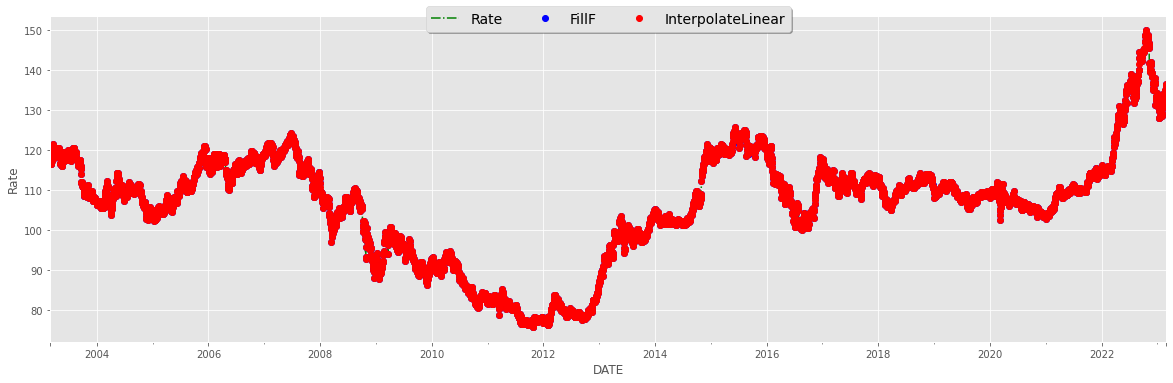

In [11]:
### plot the data after imputation

compare_df = exchange[['Rate', 'FillF', 'InterpolateLinear']]
compare_df.plot(style=['g-.', 'bo', 'ro'], figsize=(20,6));
plt.ylabel('Rate');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 14} );

In [12]:
# Retain only the column with best interpolation
exchange = exchange.drop(columns=[col for col in exchange.columns if col != 'InterpolateLinear'])
exchange = exchange.rename(columns={'InterpolateLinear':'Rate'})

## Mudança de frequência temporal para Mensal

In [13]:
exchange_month = exchange.resample(rule='MS').mean()
exchange_month.head()

,Rate
DATE,
2003-03-01,118.687143
2003-04-01,119.895000
2003-05-01,117.351591
2003-06-01,118.329048
2003-07-01,118.672609


Text(0.5, 1.0, 'Japanese Yen to U.S. Dollar Spot Exchange Rate')

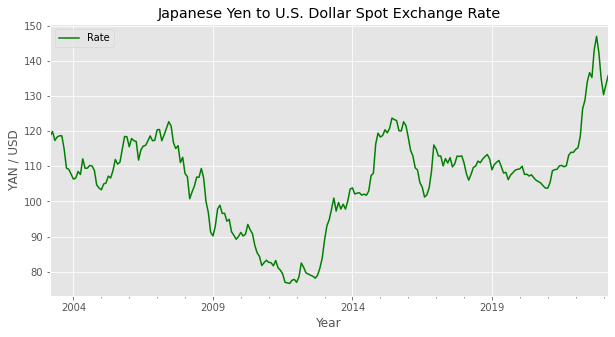

In [14]:
plt.style.use('ggplot')
ax = exchange_month.plot(color='green', grid=True, figsize=(10,5))
ax.set_xlabel('Year')
ax.set_ylabel('YAN / USD')
ax.set_title('Japanese Yen to U.S. Dollar Spot Exchange Rate') 

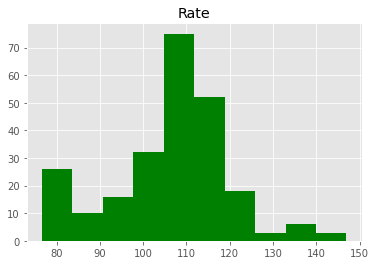

In [15]:
#exchange_month['val_log'] = np.log(exchange_month)
exchange_month.hist(color='green')
plt.show()

In [16]:
exchange_month.describe()

,Rate
count,241.000000
mean,106.496901
std,13.695248
min,76.646429
25%,100.145476
50%,108.747273
75%,114.828810
max,146.971429


In [17]:
exchange_month.min()

Rate    76.646429
dtype: float64

In [18]:
exchange_month[exchange_month['Rate'] == exchange_month['Rate'].min()]

,Rate
DATE,
2011-10-01,76.646429


## Divisão Treino/Teste

In [19]:
split = round(len(exchange)*0.9)
exch_train, exch_test = exchange_month[0:split], exchange_month[split:]

In [20]:
exch_train.head()

,Rate
DATE,
2003-03-01,118.687143
2003-04-01,119.895000
2003-05-01,117.351591
2003-06-01,118.329048
2003-07-01,118.672609


## Verificação das componentes de Tendência e Sazonalidade

<Axes: xlabel='DATE', ylabel='Resid'>

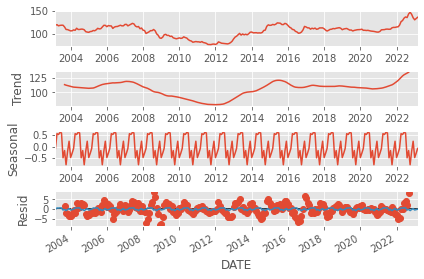

In [21]:
# proced with the time series decomposition
result=seasonal_decompose(exch_train, model='additive')

# plot time series component
result.plot()

# plot only the seasonal component
result.seasonal.plot()

In [22]:
test1 = adfuller(exch_train)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.6278327150284534
We do not reject the H0: non-stationary time series <-> we have a unit root


## Primeira Diferenciação

<Axes: xlabel='DATE'>

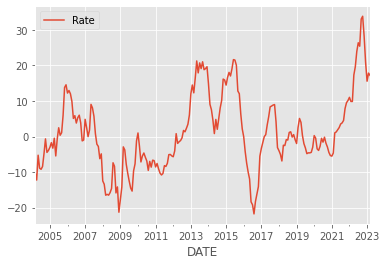

In [23]:
exch_train = exch_train.diff(12).dropna()

exch_train.plot()

<Axes: xlabel='DATE', ylabel='Resid'>

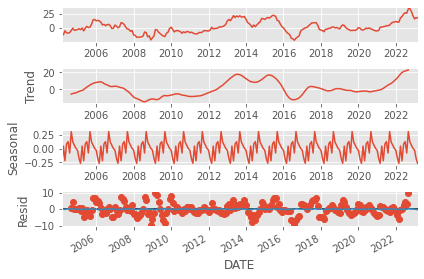

In [24]:
# proced with the time series decomposition
result=seasonal_decompose(exch_train, model='additive')

# plot time series component
result.plot()

# plot only the seasonal component
result.seasonal.plot()

In [25]:
test2 = adfuller(exch_train)
print("p-value =", test2[1])

if test2[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.40030342946074426
We do not reject the H0: non-stationary time series <-> we have a unit root


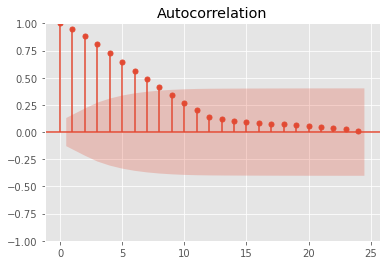

In [33]:
plot_acf(exch_train)
plt.show()

c:\Users\usr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


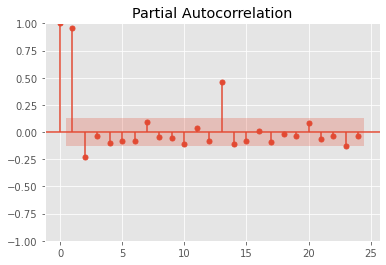

In [34]:
plot_pacf(exch_train)
plt.show()

## 2ª Diferenciação

<Axes: xlabel='DATE'>

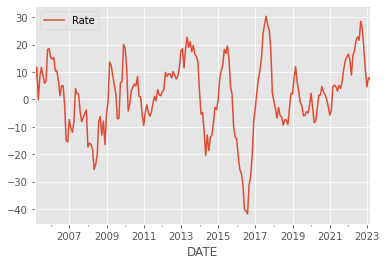

In [27]:
exch_train3 = exch_train.diff(12).dropna()
exch_train3.plot()

<Axes: xlabel='DATE', ylabel='Resid'>

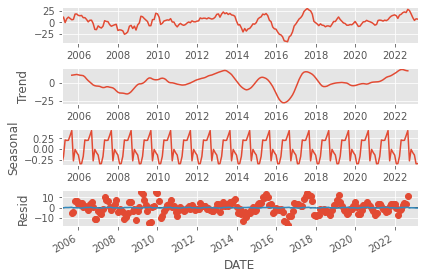

In [28]:
# proced with the time series decomposition
result3=seasonal_decompose(exch_train3, model='additive')

# plot time series component
result3.plot()

# plot only the seasonal component
result3.seasonal.plot()

In [29]:
test3 = adfuller(exch_train3)
print("p-value =", test3[1])

if test2[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.07355849857600717
We do not reject the H0: non-stationary time series <-> we have a unit root


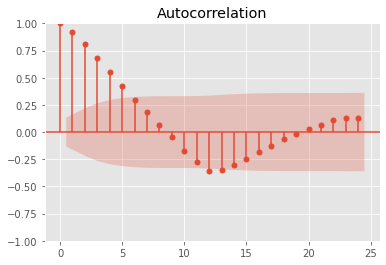

In [35]:
plot_acf(exch_train3)
plt.show()

c:\Users\usr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


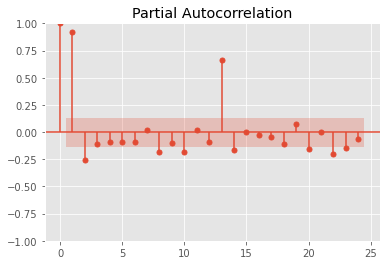

In [36]:
plot_pacf(exch_train3)
plt.show()

## 3ª Diferenciação

p-value = 0.016719552398371623


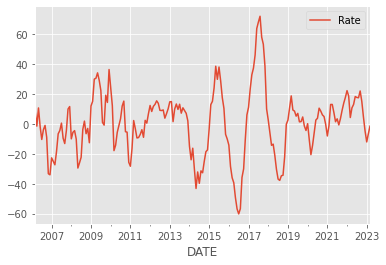

In [30]:
exch_train4 = exch_train3.diff(12).dropna()
exch_train4.plot()

test3 = adfuller(exch_train4)
print("p-value =", test3[1])

if test3[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

<Axes: xlabel='DATE', ylabel='Resid'>

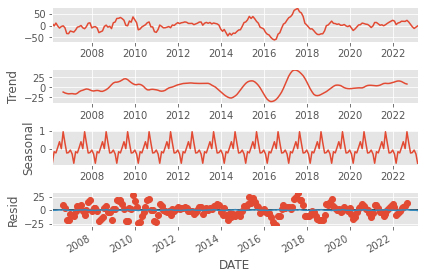

In [31]:
# proced with the time series decomposition
result4=seasonal_decompose(exch_train4, model='additive')

# plot time series component
result4.plot()

# plot only the seasonal component
result4.seasonal.plot()

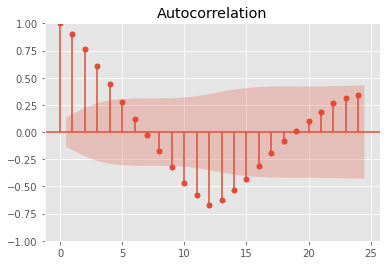

In [37]:
plot_acf(exch_train4)
plt.show()

c:\Users\usr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


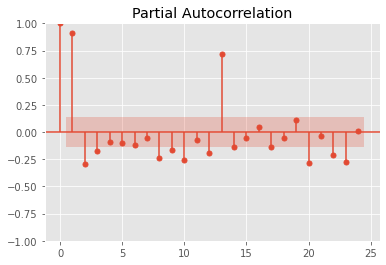

In [40]:
plot_pacf(exch_train4)
plt.show()

# Guardar em ficheiro 

Após todo o tratamento realizado à série temporal, esta é armazenada em ficheiro, para posterior uso noutros notebooks.

In [32]:
exch_train.to_csv('yan-usd.csv')